### Import Packages & Setting

In [92]:
# Initiate: import modules
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
import en_core_web_sm
import json 
from spacy import displacy
import swifter

In [78]:
yelp_dataset_dir = '/Users/yangsong/Desktop/Projects/yelp_data_challenge/yelp_dataset/yelp_academic_dataset_review.json'
colours = ['#4a4e4d', '#0e9aa7', '#3da4ab', '#f6cd61', '#fe8a71']
large = 30
med = 20
small = 15
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (large, med),
          'axes.labelsize': large,
          'axes.titlesize': large,
          'xtick.labelsize': large,
          'ytick.labelsize': large,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('ggplot')

### Data Loading

In [17]:
size = 100000
review_json = pd.read_json(yelp_dataset_dir, 
                      lines=True,
                      chunksize=size)
review_df = pd.DataFrame()

In [18]:
# on include the first 100k reviews
for review_chunck in review_json:
    review_df = pd.concat([review_df, review_chunck])
    break

In [23]:
nlp = en_core_web_sm.load()

In [56]:
review_df.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,iCQpiavjjPzJ5_3gPD5Ebg,0,2011-02-25,0,x7mDIiDB3jEiPGPHOmDzyw,2,The pizza was okay. Not the best I've had. I p...,0,msQe1u7Z_XuqjGoqhB0J5g


(0, 60000)

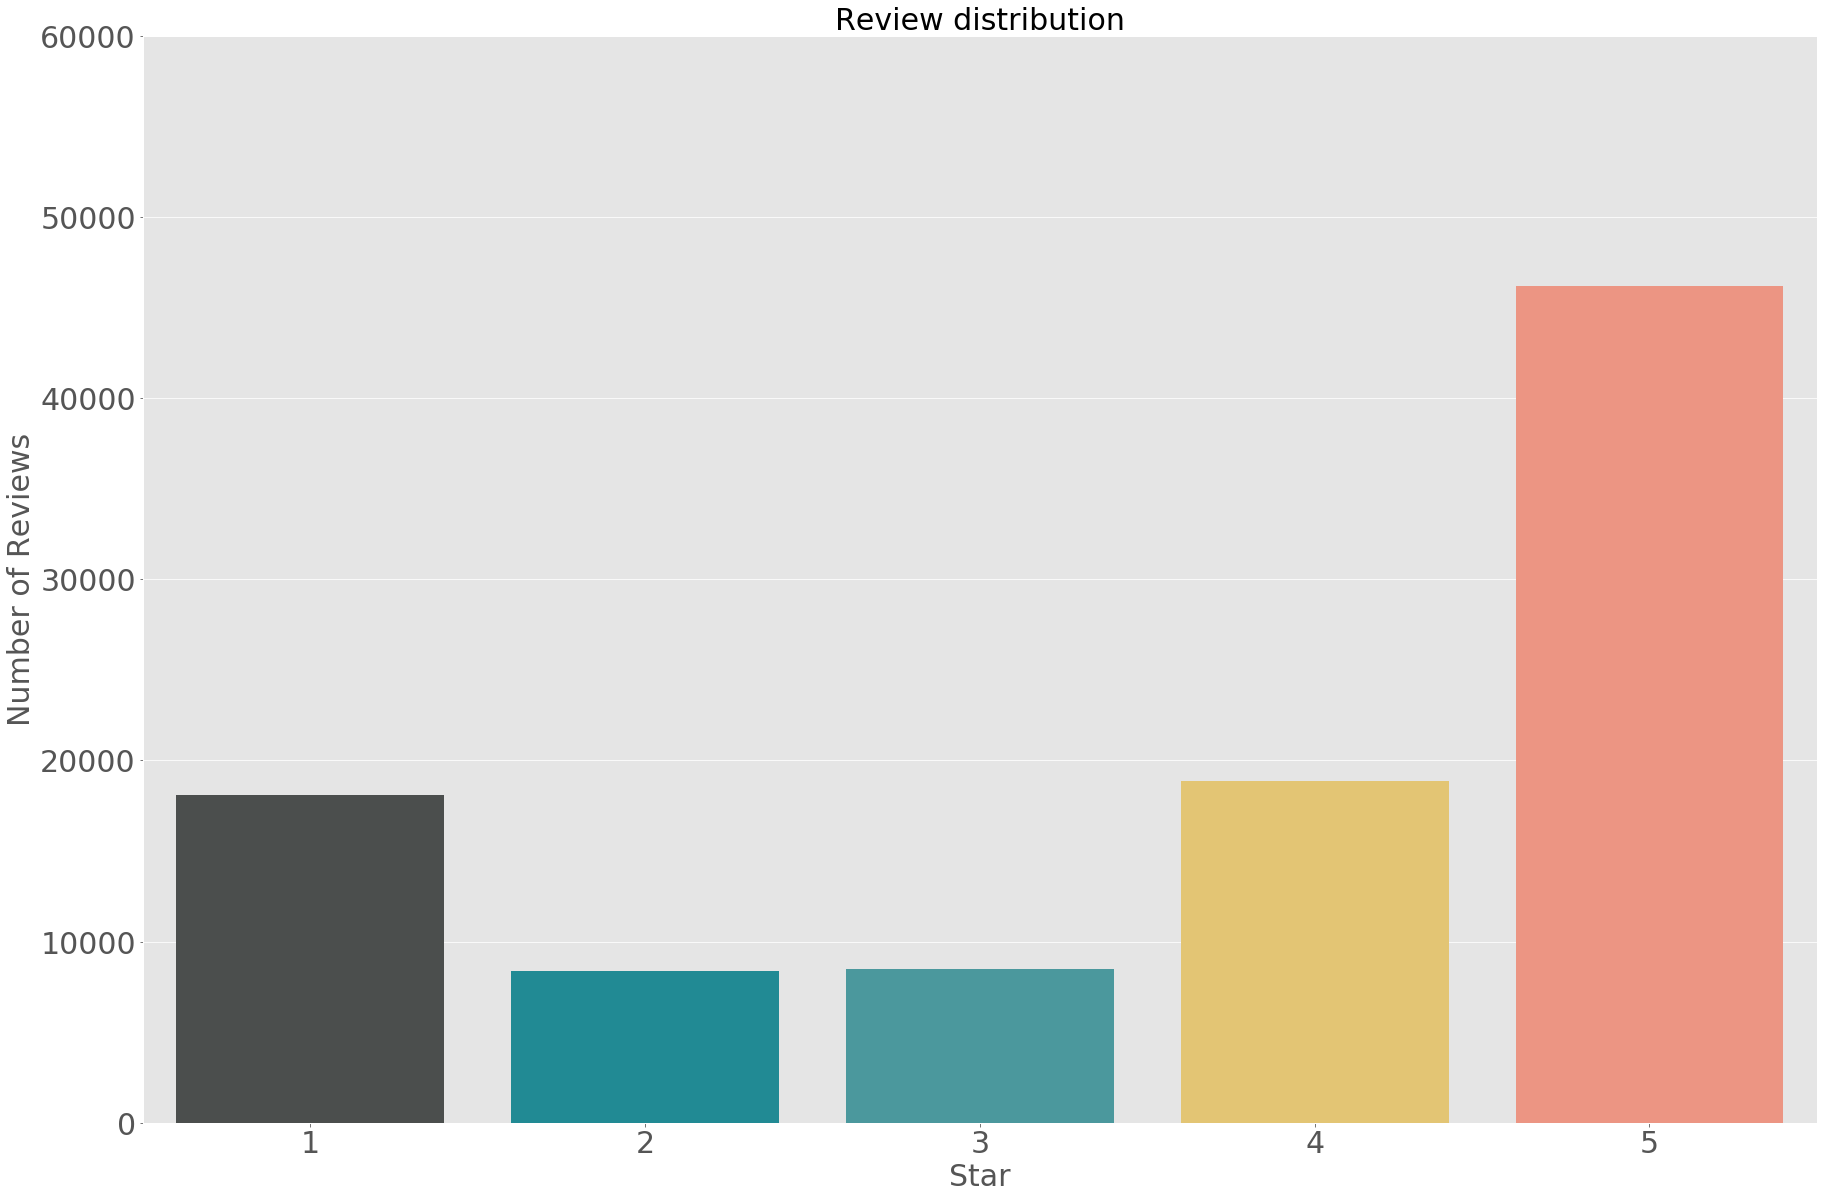

In [81]:
sns.countplot(x="stars", data=review_df, palette=colours)
plt.title("Review distribution", fontsize=30)
plt.xlabel("Star", fontsize=30)
plt.ylabel("Number of Reviews", fontsize=30)
plt.ylim(0, 60000)

### Review Length Distribution

In [90]:
def generate_text_length(text):
    doc = nlp(text)
    return len([token for token in doc if not token.is_punct])

In [93]:
review_df['review_length'] = \
    review_df['text'].swifter.apply(lambda x : generate_text_length(x))

In [94]:
review_df.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,review_length
0,iCQpiavjjPzJ5_3gPD5Ebg,0,2011-02-25,0,x7mDIiDB3jEiPGPHOmDzyw,2,The pizza was okay. Not the best I've had. I p...,0,msQe1u7Z_XuqjGoqhB0J5g,90
1,pomGBqfbxcqPv14c3XH-ZQ,0,2012-11-13,0,dDl8zu1vWPdKGihJrwQbpw,5,I love this place! My fiance And I go here atl...,0,msQe1u7Z_XuqjGoqhB0J5g,58
2,jtQARsP6P-LbkyjbO1qNGg,1,2014-10-23,1,LZp4UX5zK3e-c5ZGSeo3kA,1,Terrible. Dry corn bread. Rib tips were all fa...,3,msQe1u7Z_XuqjGoqhB0J5g,30


### Noun Phrases Extraction

### POS Tagging + Name Entity Recog

In [25]:
review_df.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,iCQpiavjjPzJ5_3gPD5Ebg,0,2011-02-25,0,x7mDIiDB3jEiPGPHOmDzyw,2,The pizza was okay. Not the best I've had. I p...,0,msQe1u7Z_XuqjGoqhB0J5g


In [45]:
text = review_df.loc[0,'text']
doc = nlp(text)

In [85]:
# tokens
for token in doc[:5]:
    print('"' + token.text + '"')

"I"
"have"
"been"
"an"
"Emerald"


In [36]:
# Charaters of the word
for token in doc[:10]:
    print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}".format(
        token.text,
        token.idx,
        token.lemma_,
        token.is_punct,
        token.is_space,
        token.shape_,
        # part of speech
        token.pos_,
        # tagging
        token.tag_
    ))

The	0	the	False	False	Xxx	DET	DT
pizza	4	pizza	False	False	xxxx	NOUN	NN
was	10	be	False	False	xxx	AUX	VBD
okay	14	okay	False	False	xxxx	ADJ	JJ
.	18	.	True	False	.	PUNCT	.
Not	20	not	False	False	Xxx	PART	RB
the	24	the	False	False	xxx	DET	DT
best	28	good	False	False	xxxx	ADJ	JJS
I	33	-PRON-	False	False	X	PRON	PRP
've	34	have	False	False	'xx	AUX	VB


In [39]:
# entity
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Biaggio 52 59 ORG
Flamingo / Fort Apache 65 87 FAC
Cosmo 158 163 ORG
Biaggio 233 240 PERSON
italian 284 291 NORP


In [40]:
displacy.render(doc, style='ent', jupyter=True)

### Topic 

### Embedding